# Image Segmentation Using K-Means Clustering

In [28]:
#importing
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [29]:
#import random pic
image = cv2.imread('../dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg')

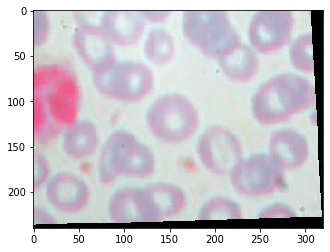

In [30]:
#show pic
plt.imshow(image)

In [31]:
#normalize
img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

#resize & reshape image
img = img.reshape((-1,3))

# convert to np.float32
img = np.float32(img)

print(image.shape)

(240, 320, 3)


## K-Means Clustering

We use K = 4 because the images only have 4 colors.

In [32]:
# define criteria
criteria = (
    #this is is the criteria of K-Means Algorithm
    #the algorithm is stopped if 
    
    cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
    
    #max_iter has reached 10 and 
    10, 
    
    #epsilon has reached 1.0
    1.0)
#we use the above numbers because the image has only 4 dominant colors

#define K, or how many colors
K = 4

#apply KMeans
#we're only going to use center and  so we can leave the other variable out
_, label, center = cv2.kmeans(
    #data is the image
    data = img, 
    
    #K is the number of clusters
    K = K, 
    
    #bestLabels is you have an array of integers that stores indices
    bestLabels = None, 
    
    #criteria is the maximum iteration of K-Means Algorithm, mentioned above
    criteria = criteria, 
    
    #specify the number of times the algorithm is executed using different initial labellings
    attempts = 10, 
    
    #we use random center and initial center
    flags = cv2.KMEANS_RANDOM_CENTERS)

#returns compactness, we leave that out
#returns label for each pixel
#return center, the matrix of cluster center

In [33]:
# Now convert back into uint8
center = np.uint8(center)
res = center[label.flatten()]

#make original image
segmented_image = res.reshape((image.shape))

At this point, the image has been segmented.

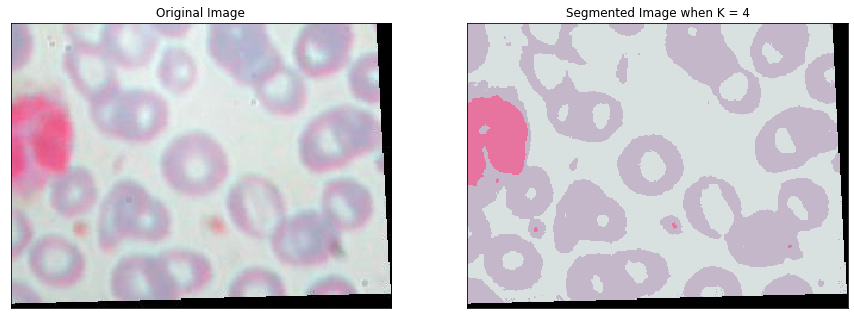

In [34]:
#plot image side by side
figure_size = 15
plt.figure(figsize = (figure_size, figure_size))

plt.subplot(1,2,1), plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(segmented_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

## This step is to add a bounding line to emphasize the nucleus and red blood cell

Define the boundaries (range of color) and do bitwise AND to the image.<br>
The boundaries are got with manual calibration, meaning that we determine the boundaries by tuning the boundaries and apply the boundaries to the image again and again until the result is outputting what we're hoping for.<br>
It's not the easiest method, but it gets the job done and the result is tolerable.

### Nucleus Image

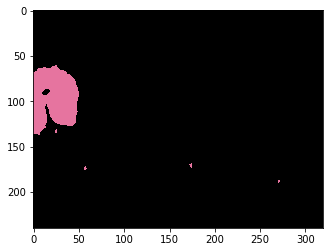

In [35]:
# define the list of boundaries
#[Blue, Green, Red] because cv2 uses that

#example, if a pixel has a color of BGR(150,150,150) than it won't be removed by the mask
boundaries = [([170, 50, 50], [255, 125, 125]),
             ([190, 125, 100], [255, 185, 190]),
             ([190, 100, 100], [255, 125, 190])]


for (lower, upper) in boundaries:
    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    
    # find the colors within the specified boundaries and apply
    # the mask is like a filter of an image 
    mask = cv2.inRange(segmented_image, lower, upper)
    
    #bitwise and will get rid of unwanted segment
    nucleus_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
    
    
#plot the image    
plt.imshow(nucleus_image)

Convert image to black&white to find the contour line.

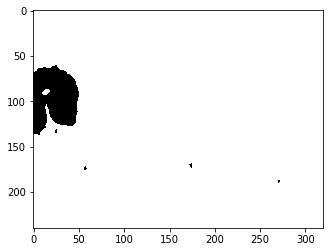

In [36]:
# Convert to grayscale 
img_gray = cv2.cvtColor(nucleus_image, cv2.COLOR_RGB2GRAY)

# Apply the thresholding
a = img_gray.max()  

#we're only going to use thresh, so we can leave the other variable
_, thresh = cv2.threshold(img_gray, a/2+60, a,cv2.THRESH_BINARY_INV)

#plot the black&white image
plt.imshow(thresh, cmap = 'gray')

#cv2 can easily find contours if the images is like shown below
contours, _ = cv2.findContours(image = thresh, 
                                mode = cv2.RETR_TREE, 
                                method = cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours 
nucleus_contours = sorted(contours, key = cv2.contourArea, reverse = True)

#then, we draw the contour onto the original image
final = cv2.drawContours(image, nucleus_contours, contourIdx = -1, 
                         color = (0, 0, 255), thickness = 2)


### Red Blood Cell Image

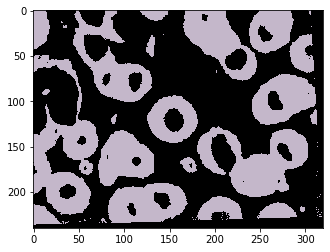

In [37]:
#the boundaries are different from the nuclues boundaries
boundaries = [([100,100,100],[190,190,190]),
              ([100,100,100],[210,194,196]),
              ([100,100,100],[194,210,194]),
              ([100,100,100],[196,194,210])]
for (lower, upper) in boundaries:
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    mask = cv2.inRange(segmented_image, lower, upper)
    
    #we use different variable name so it won't be mixed up
    rbc_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
plt.imshow(rbc_image)

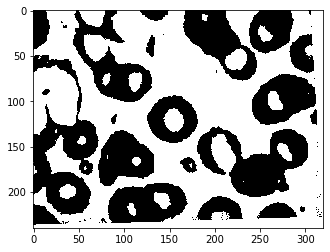

In [38]:
img_gray = cv2.cvtColor(rbc_image, cv2.COLOR_RGB2GRAY)
a = img_gray.max()  
_, thresh = cv2.threshold(img_gray, a/2+60, a,cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap = 'gray')
contours, _ = cv2.findContours(image = thresh, 
                                mode = cv2.RETR_TREE, 
                                method = cv2.CHAIN_APPROX_SIMPLE)
rbc_contours = sorted(contours, key = cv2.contourArea, reverse = True)
final = cv2.drawContours(image, rbc_contours, contourIdx = -1, 
                         color = (255, 0, 0), thickness = 1)

cv2 can give color information to write the boundaries, but destroy the kernel so you have to restart the kernel.

In [39]:
# show the images
# cv2.imshow("images", np.hstack([segmented_image,rbc_image]))
# cv2.waitKey(0)

Finally, plot the image.

Blue is the nucleus
Red is the red blood cell(s)


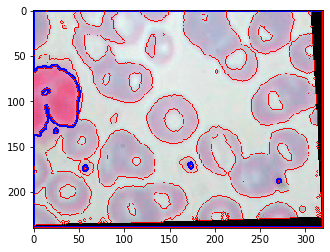

In [40]:
#plot image
plt.imshow(image)
print('Blue is the nucleus')
print('Red is the red blood cell(s)')

Note that, the latest contour line will be drawn on top of the last contour line.

## Too augemented images cannot be segmented

Those images will produce only black image on the nucleus detection, thus will only show the RBC bounding line.

In [6]:
#too augemnted image
image = cv2.imread('../dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_26_5915.jpeg')

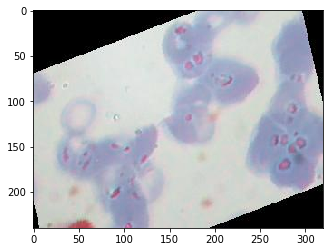

In [7]:
plt.imshow(image)

In [8]:
img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
img = img.reshape((-1,3))
img = np.float32(img)
print(image.shape)

(240, 320, 3)


In [9]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
_, label, center = cv2.kmeans(img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [10]:
center = np.uint8(center)
res = center[label.flatten()]
segmented_image = res.reshape((image.shape))

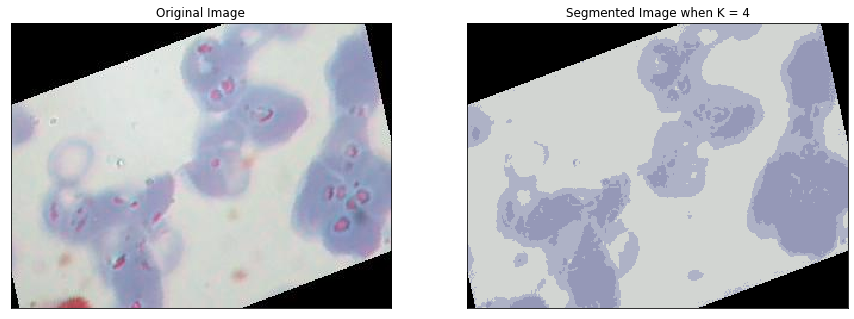

In [11]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(segmented_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

### Nucleus Image

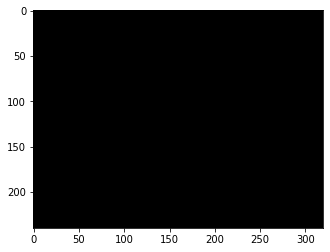

In [12]:
boundaries = [([170, 50, 50], [255, 125, 125]),
             ([190, 125, 100], [255, 185, 190]),
             ([190, 100, 100], [255, 125, 190])]

for (lower, upper) in boundaries:
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    mask = cv2.inRange(segmented_image, lower, upper)
    nucleus_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
    
plt.imshow(nucleus_image)

We can drop the image by getting camporing it to a black image.

In [13]:
im = Image.fromarray(nucleus_image) 

#use pilow to getcolors
imgColor = Image.Image.getcolors(im) 

#compare it
#all black image will only have 1 color
if len(imgColor) <= 1 :
    print('Image is all black')

Image is all black


And apply it to the boundaries.

In [16]:
boundaries = [([170, 50, 50], [255, 125, 125]),
             ([190, 125, 100], [255, 185, 190]),
             ([190, 100, 100], [255, 125, 190])]

for (lower, upper) in boundaries:
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    mask = cv2.inRange(segmented_image, lower, upper)
    
    temp_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
    im = Image.fromarray(temp_image) 
    imgColor = Image.Image.getcolors(im) 

    #compare it
    if len(imgColor) > 1:
        nucleus_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
        plt.imshow(nucleus_image)

In [17]:
#we draw the contour if image is not all black
if len(imgColor) > 1:
    img_blur = cv2.bilateralFilter(nucleus_image, d = 7, sigmaSpace = 75, sigmaColor =75)
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)
    a = img_gray.max()  
    _, thresh = cv2.threshold(img_gray, a/2+60, a,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap = 'gray')
    contours, hierarchy = cv2.findContours(image = thresh, 
                                           mode = cv2.RETR_TREE, 
                                           method = cv2.CHAIN_APPROX_SIMPLE)
    nucleus_contours = sorted(contours, key = cv2.contourArea, reverse = True)
    final = cv2.drawContours(image, nucleus_contours, contourIdx = -1, 
                             color = (0, 0, 255), thickness = 2)

And skip the contouring of the nucleus.

### Red Blood Cell Image

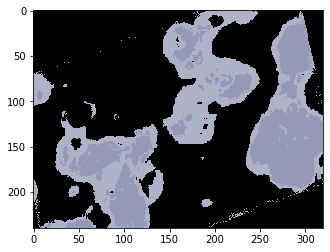

In [22]:
boundaries = [([100,100,100],[190,190,190]),
              ([100,100,100],[210,194,196]),
              ([100,100,100],[194,210,194]),
              ([100,100,100],[196,194,210])]

for (lower, upper) in boundaries:
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    mask = cv2.inRange(segmented_image, lower, upper)
    temp_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
    im = Image.fromarray(temp_image) 
    imgColor = Image.Image.getcolors(im) 

    #compare it
    if len(imgColor) > 1:
        rbc_image = cv2.bitwise_and(segmented_image, segmented_image, mask = mask)
    
plt.imshow(rbc_image)

In [26]:
im = Image.fromarray(rbc_image) 
imgColor = Image.Image.getcolors(im) 

if len(imgColor) <= 1:
    print('image is too augmented')

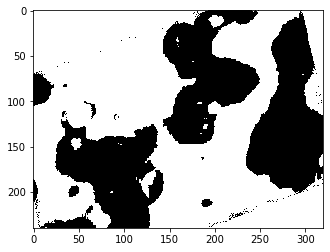

In [27]:
if len(imgColor) > 1 :
    img_blur = cv2.bilateralFilter(rbc_image, d = 7, sigmaSpace = 75, sigmaColor =75)
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)
    a = img_gray.max()  
    _, thresh = cv2.threshold(img_gray, a/2+60, a,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap = 'gray')
    contours, hierarchy = cv2.findContours(image = thresh, 
                                           mode = cv2.RETR_TREE, 
                                           method = cv2.CHAIN_APPROX_SIMPLE)
    rbc_contours = sorted(contours, key = cv2.contourArea, reverse = True)
    final = cv2.drawContours(image, rbc_contours, contourIdx = -1, 
                             color = (255, 0, 0), thickness = 2)

blue is the nucleus
red is the red blood cell(s)


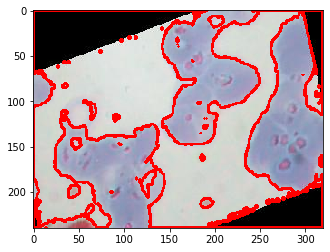

In [25]:
plt.imshow(image)
print('blue is the nucleus')
print('red is the red blood cell(s)')

## Reference

<b>Blog</b><br>

Understanding K-means Clustering in Machine Learning<br>
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1<br>

OpenCV and Python Color Detection<br>
https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/<br>

Computer Vision for Beginners: Part 4<br>
https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208

<br><b>Documentation</b><br>

Clustering<br>
https://docs.opencv.org/2.4/modules/core/doc/clustering.html<br>

K-Means Clustering in OpenCV<br>
https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html<br>

Structural Analysis and Shape Descriptors<br>
https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html<br>

Image Thresholding<br>
https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.htmlcv<br>

ImageColor<br>
https://pillow.readthedocs.io/en/3.0.x/reference/ImageColor.html